In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import seaborn as sns
import nltk
import missingno as msno
from mergeStock import merge

In [9]:
df = merge('TSLA')

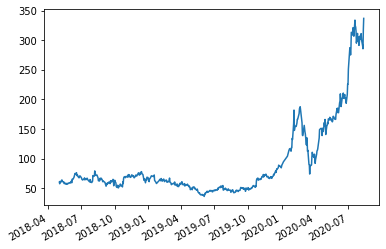

In [10]:
df.close.plot()

In [32]:
# feature engineering 
df

,popularity_daily_avg,popularity_open,popularity_close,popularity_daily_change,close,volume,close_T-1,Y,returnPrev1,VIX Open,...,VIX Close,VIX_Close_T-1,vix_returnPrev1,vader_mean,vader_std,comment_count,pos_count,neg_count,pos_mean,neg_mean
2018-05-02,81038.000000,81038.0,81038.0,0.000000,60.27,46914055,62.48,0,-0.036012,15.48,...,15.97,15.49,0.030517,-0.000119,0.583121,21.0,10.0,10.0,0.517080,-0.517330
2018-05-03,81588.473684,80137.0,83646.0,0.043788,57.55,86850756,60.27,1,-0.046180,15.78,...,15.90,15.97,-0.004393,-0.026836,0.708560,14.0,6.0,7.0,0.681550,-0.637857
2018-05-04,83466.958333,83646.0,83240.0,-0.004854,61.59,43866149,57.55,0,0.067845,15.94,...,14.77,15.90,-0.073721,-0.069020,0.513871,10.0,4.0,5.0,0.474625,-0.517740
2018-05-07,82922.200000,83237.0,81129.0,-0.025325,60.77,44945152,61.59,1,-0.013403,15.32,...,14.75,14.77,-0.001355,0.324940,0.356709,10.0,9.0,1.0,0.417778,-0.510600
2018-05-08,80950.500000,81129.0,80656.0,-0.005830,63.02,31053817,60.77,1,0.036356,14.53,...,14.71,14.75,-0.002716,0.305180,0.504772,5.0,3.0,1.0,0.614700,-0.318200
2018-05-09,80498.875000,80656.0,79994.0,-0.008208,64.03,29073681,63.02,0,0.015900,14.54,...,13.42,14.71,-0.091781,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
2018-05-10,79885.875000,79994.0,79683.0,-0.003888,61.00,28654801,64.03,1,-0.048478,13.36,...,13.23,13.42,-0.014259,-0.333250,0.663530,4.0,1.0,3.0,0.636900,-0.656633
2018-05-11,79786.541667,79683.0,80092.0,0.005133,61.27,23549917,61.00,0,0.004416,13.22,...,12.65,13.23,-0.044830,-0.014233,0.558894,6.0,3.0,2.0,0.413033,-0.662250
2018-05-14,80439.333333,80094.0,81389.0,0.016169,60.89,37320068,61.27,0,-0.006221,12.95,...,12.93,12.65,0.021893,0.429867,0.577244,3.0,2.0,1.0,0.725450,-0.161300
2018-05-15,82460.541667,81389.0,84671.0,0.040325,57.96,49232460,60.89,1,-0.049316,13.13,...,14.63,12.93,0.123524,0.065525,1.033786,4.0,2.0,2.0,0.959300,-0.828250


In [14]:
def dataProcessing(df, scaler='MinMaxScaler', split=0.9):
    # define input variable
    X = ['popularity_daily_avg', 'popularity_daily_change', 
         'close','volume', 'returnPrev1', 
#          'returnPrev5',
         'VIX Close','vix_returnPrev1', 
         'vader_mean', 'vader_std', 'comment_count', 'pos_count'] #, 'neg_count', 'pos_mean', 'neg_mean']
    
    # define target variable
    Y = ['Y']
    df[Y] = df[Y].astype(int)
    
    # train test split 
    train = df[:int(len(df)*split)]
    test = df[int(len(df)*split):]
    
    # MinMax Scaler
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    scaler = MinMaxScaler()
    if scaler == 'MinMax':
        train[X] = scaler.fit_transform(train[X])
        test[X] = scaler.transform(test[X])
    if scaler == 'Smooth':
            # Train the Scaler with training data & smooth data
        smoothing_window_size = 90
        for di in range(0,len(train),smoothing_window_size):
            try:
                scaler.fit(train[X][di:di+smoothing_window_size])
                train.loc[train.index[di]:train.index[di+smoothing_window_size],X] = scaler.transform(train.loc[train.index[di]:train.index[di+smoothing_window_size],X])
            except:
                break
        # normalize the last bit
        print(di)
        scaler.fit(train[X][di:])
    #         train[X][di+smoothing_window_size:] = scaler.transform(train[X][di+smoothing_window_size:])
        train.loc[train.index[di]:,X] = scaler.transform(train.loc[train.index[di]:,X])
        test[X] = scaler.transform(test[X])
        print('finished!')
        

    return train[X], train[Y], test[X], test[Y]
#     return train[X].values, train_Y, test[X].values, test[Y].values



In [15]:
train_X, train_Y, test_X, test_Y = dataProcessing(df)

In [16]:
train_X

,popularity_daily_avg,popularity_daily_change,close,volume,returnPrev1,VIX Close,vix_returnPrev1,vader_mean,vader_std,comment_count,pos_count
2018-05-02,81038.000000,0.000000,60.27,46914055,-0.036012,15.97,0.030517,-0.000119,0.583121,21.0,10.0
2018-05-03,81588.473684,0.043788,57.55,86850756,-0.046180,15.90,-0.004393,-0.026836,0.708560,14.0,6.0
2018-05-04,83466.958333,-0.004854,61.59,43866149,0.067845,14.77,-0.073721,-0.069020,0.513871,10.0,4.0
2018-05-07,82922.200000,-0.025325,60.77,44945152,-0.013403,14.75,-0.001355,0.324940,0.356709,10.0,9.0
2018-05-08,80950.500000,-0.005830,63.02,31053817,0.036356,14.71,-0.002716,0.305180,0.504772,5.0,3.0
2018-05-09,80498.875000,-0.008208,64.03,29073681,0.015900,13.42,-0.091781,0.000000,0.000000,0.0,0.0
2018-05-10,79885.875000,-0.003888,61.00,28654801,-0.048478,13.23,-0.014259,-0.333250,0.663530,4.0,1.0
2018-05-11,79786.541667,0.005133,61.27,23549917,0.004416,12.65,-0.044830,-0.014233,0.558894,6.0,3.0
2018-05-14,80439.333333,0.016169,60.89,37320068,-0.006221,12.93,0.021893,0.429867,0.577244,3.0,2.0
2018-05-15,82460.541667,0.040325,57.96,49232460,-0.049316,14.63,0.123524,0.065525,1.033786,4.0,2.0


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn import metrics

In [22]:
rf = RandomForestRegressor(n_estimators = 10000, random_state = 42)
# Train the model on training data
rf.fit(train_X, train_Y);

/Users/melodylui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
predictions = rf.predict(test_X)

In [46]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for threshold in thresholds:
    classified_prediction = []
    for ele in predictions:
        if ele <= threshold:
            classified_prediction.append(0)
        else:
            classified_prediction.append(1)
    errors = abs(classified_prediction - test_Y['Y'])
    print(f'Mean Absolute Error with threshold {threshold}:', round(np.mean(errors), 2))

Mean Absolute Error with threshold 0.3: 0.46
Mean Absolute Error with threshold 0.4: 0.47
Mean Absolute Error with threshold 0.5: 0.58
Mean Absolute Error with threshold 0.6: 0.6
Mean Absolute Error with threshold 0.7: 0.51
Mean Absolute Error with threshold 0.8: 0.51
